# 3. Coupled eco-evolutionary model with LEM

A simple example showcasing how to execute the eco-evolutionary model **coupled** to FastScape. 

## Import libraries

We first need to import the libraries and methods as we did before and add our eco-evolutionary model (**adascape_IR12_model**) as a component of [FastScape LEM](https://fastscape.readthedocs.io/en/latest/).

In [1]:
import numpy as np
import extra_func as ext
import matplotlib.pyplot as plt
%load_ext xsimlab.ipython
from adascape.fastscape_ext import adascape_IR12_model

We can explore the processes included in the **adascape_IR12_model** by simply tipping the name of the model in the python console

In [2]:
adascape_IR12_model

<xsimlab.Model (24 processes, 53 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                   [in] random seed
surf2erode
init_erosion
diffusion
    diffusivity            [in] () or ('y', 'x') diffusivity (trans...
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    c

We can also visulize the links between those components 

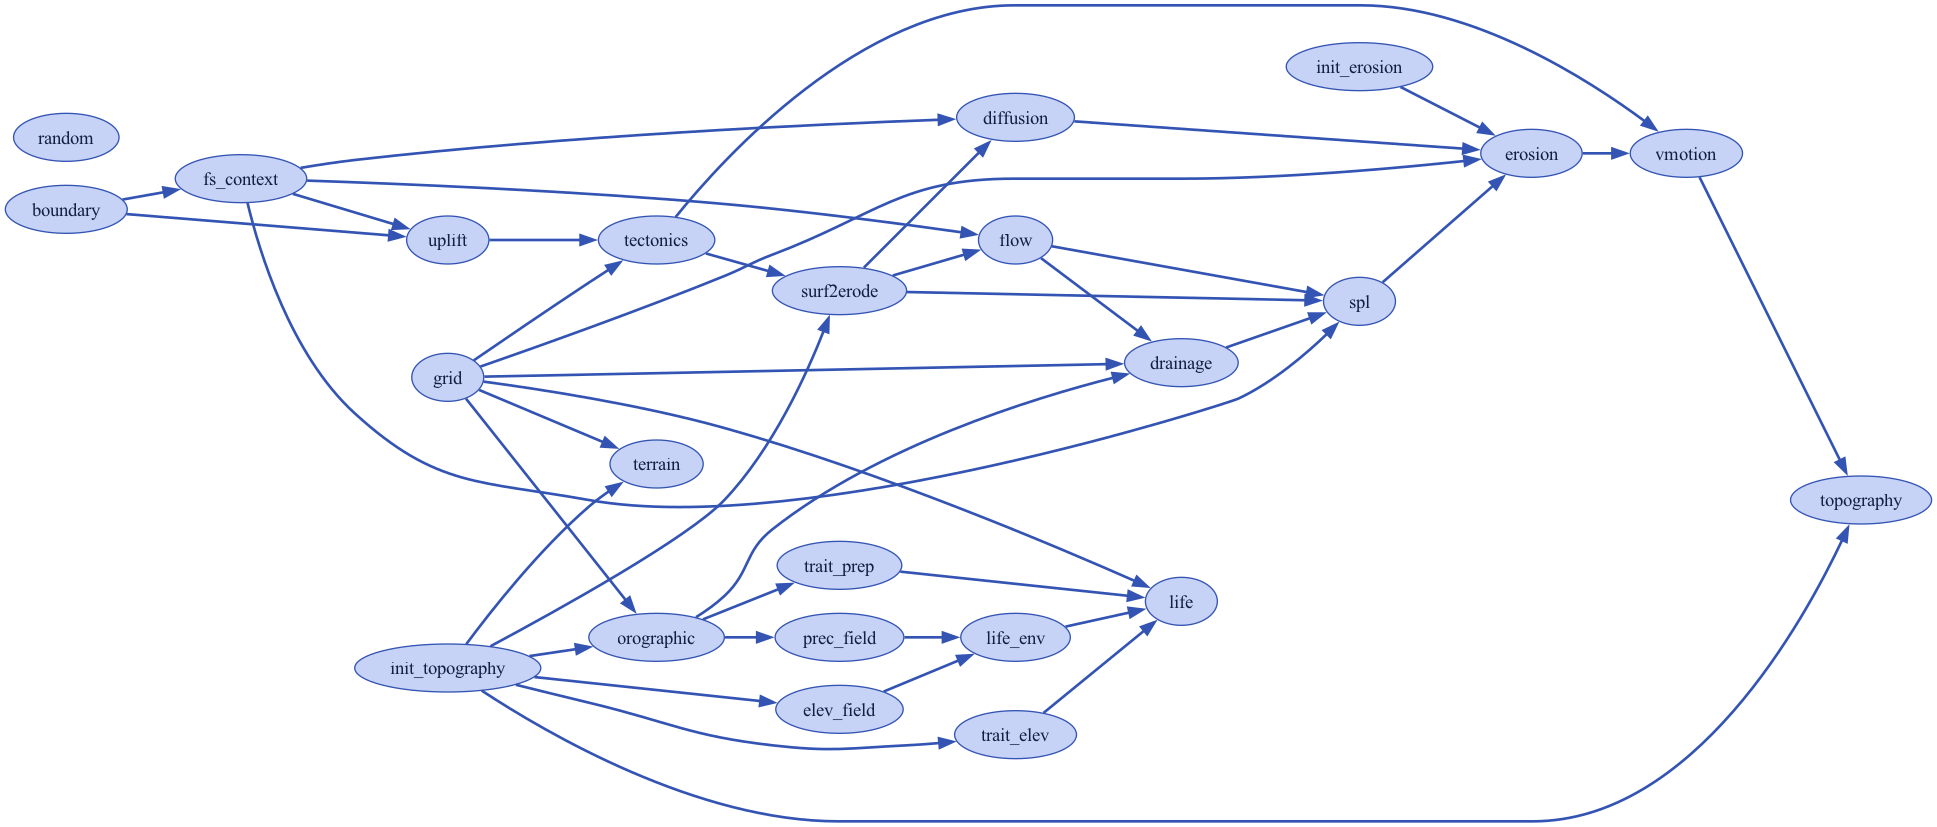

In [3]:
adascape_IR12_model.visualize()

To start building our model, we will use the *create_setup* magic command to build our model and adjust the parameter values:
```python
%create_setup adascape_IR12_model --default --verbose
```

You will see that we need to specify several parameters. First, let's specify the clocks to use in our simulation. In particular, we need to specify the actual clock we use to compute the solution also called the **master clock** and another clock to save the output of the model **out clock**. The latter commonly has fewer elements than the master clock. To create these clocks let's assume we will model the evolution of an orogen for 1 Myr. Then we will create an array that contains 1000 elements from 0 to 1 million using [numpy.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) function as:
```python 
the_clock = np.linspace(0, 1e6, 1001) 
```

We then specify both clocks as a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), where the **time clock** is the clock array and the **out clock** is a subsample of 100 elements of the clock array:
```python 
clocks = {'time': the_clock,
         'out': the_clock[::10]}
```

Since we pass two clocks to our setup, we would need to let the program know which of these two clocks is the **master clock**. We do that by adding the following option to our setup:
```python
master_clock='time',
```

Second, we need to specify the grid dimensions by passing a [list](https://docs.python.org/3/tutorial/introduction.html#lists) with the number of grid nodes for the y and x coordinates, which we will consider to be 100 by 100 grid nodes and can be specified this way:
```python
nx=201
ny=101
input_vars={
    'grid__shape': [ny, nx],
    ...
    }
```
and these nodes will have a maximum extent of 100 by 100 km, which one can specify as:
```python
lx=100e3
ly=100e3
input_vars={
    ...
    'grid__length': [ly, lx],
    ...
}
```

Then we need to specify the [boundary conditions](https://fastscape.readthedocs.io/en/latest/_api_generated/fastscape.processes.BorderBoundary.html#fastscape.processes.BorderBoundary) for the grid nodes in the border.
We can do this by passing a list in the order [left, right, top, bottom] and where the border status can be 
“core” (open boundary), “fixed_value” (closed boundary) and “looped” (periodic boundary). Note that at least one of 
the borders needs to be “fixed_value”. For our case we will consider:

```python
input_vars={
    ...
    'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
    ...
}
```

Third, we will need to specify the parameters related to the basic equation governing landscape evolution ([Stream Power Law](https://onlinelibrary.wiley.com/doi/full/10.1002/esp.3462)) and [orographic precipitation](https://journals.ametsoc.org/view/journals/atsc/61/12/1520-0469_2004_061_1377_altoop_2.0.co_2.xml) as implemented in [FastScape](). For the former, we will assume a constant **uplift rate** of 5e-3 m/yr, a **bedrock incision coefficient** of 1.8e-5 m/yr and a **hillslope transport coefficient** of 1e-2 $m^2/yr$. For the latter, we will set the **latitude** to 40, the **base or background precipitation** to 2.5 mm/hr, the **wind speed** to 15 m/s, the **wind direction** to 0 degrees (i.e. from south of model domain), the **water vapour scale height** to 3000 meters, and the **minimum precipitation** to 1e-4 mm/hr.

```python
input_vars={
    ...
    'uplift__rate': 5e-3,
    'spl__k_coef': 1.8e-5,
    'diffusion__diffusivity': 1e-2,
    'orographic__latitude': 40,
    'orographic__precip_base': 2.5,
    'orographic__wind_speed': 15,
    'orographic__wind_dir': 0,
    'orographic__hw': 3000,
    'orographic__precip_min': 1e-4,
    ...
    }
```

Fourth, for the eco-evolutionary model, we will **initialize a population** of 100 individuals all with the same **initial trait value** (i.e. equal initial minimum and maximum trait value) of 0.25 for the trait associated with elevation and 0.75 for the trait associated with precipitation. The relationship between the optimal trait and the environmental fields is described by a linear function with a **slope** of 0.95. As the environmental fields change during simulation, we have to set the **normalization minimum and maximum values** for the elevation field between 0 and 3700 meters and the precipitation field between 1e-3 and 3.5 mm/hr. 

```python
input_vars={
    ...
    'life__init_abundance': 100,
    'trait_elev__init_trait_min': 0.25,
    'trait_elev__init_trait_max': 0.25,
    'trait_elev__lin_slope': 0.95,
    'trait_elev__norm_min': 0,
    'trait_elev__norm_max': 3700,
    'trait_prep__init_trait_min': 0.75,
    'trait_prep__init_trait_max': 0.75,
    'trait_prep__lin_slope': 0.95,      
    'trait_prep__norm_min': 1e-3,
    'trait_prep__norm_max': 3.5,
    ...
}
```
We will set **local carrying capacity** to 50 individuals in a  **neighbourhood radius** of 2e4 m. The **dispersal variability** or $\mathbf{\sigma_d}$ will be set to 1e4 m. The **mutation probability** or $\mathbf{p_m}$ to 0.005 with a **mutation variability** or $\mathbf{\sigma_m}$ of 0.05 in trait units. Last the **environmental fitness variability** or $\mathbf{\sigma_f}$ we will set to 0.25 in trait units.


```python
input_vars={
    ...
    'life__r': 2e4,
    'life__K': 50,
    'life__sigma_d': 1e4,
    'life__p_m': 0.005,
    'life__sigma_m': 0.05,
    'life__sigma_f': 0.25,
    ...
}
```
Last, we will retrieve the following variables:

```python
output_vars={'topography__elevation': 'out',
             'orographic__precip_rate':'out'
             'life__x': 'out',
             'life__y': 'out',
             'life__traits': 'out',
             'life__taxon_id': 'out',
             'life__ancestor_id': 'out'}
```

The other input parameters we will leave with their default value.

In [4]:
# %create_setup adascape_IR12_model --default --verbose
import xsimlab as xs

random_seed = 1234
the_clock = np.linspace(0., 1e6, 1001)

ds_in = xs.create_setup(
    model=adascape_IR12_model,
    clocks={
        'time': the_clock,
        'out': the_clock[::10]
    },
    master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101, 101],
        # total grid length in (y, x)
        'grid__length': [1e5, 1e5],
        # node status at borders
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        # uplift rate
        'uplift__rate': 5e-3,
        # random seed
        'init_topography__seed': random_seed,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # bedrock channel incision coefficient
        'spl__k_coef': 1.8e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # initial number of individuals
        'life__init_abundance': 100,
        # random number generator seed
        'life__random_seed': random_seed,
        # threshold used to construct taxon clusters
        'life__taxon_threshold': 0.1,
        # Taxon definition based on common ancestry and traits ('traits') or common ancestry,
        # traits and location ('traits_location')
        'life__taxon_def': 'traits',
        # min range of individuals on x coordinate
        'life__init_x_range_min': None,
        # min range of individuals on x coordinate
        'life__init_x_range_max': None,
        # min range of individuals on y coordinate
        'life__init_y_range_min': None,
        # min range of individuals on y coordinate
        'life__init_y_range_max': None,
        # Correlation coefficient between traits, 0 means that traits are independent, where a
        # value of rho different from 0 and between -1 and 1, will determine the degree of
        # correlation betweentraits for all individuals
        'life__rho': 0,
        # trait mediated competition for a limiting resource, where the degree of trait
        # similarity is given by this parameter. If its value is =>1 all individuals in the
        # local neighbourhood are counted, but if its values is < 1 then only those
        # individuals with similar trait values are counted.
        'life__sigma_u': 2,
        # environmental fitness selectivity or width around optimal traitvalue for each
        # individual's trait
        'life__sigma_f': 0.25,
        # dispersal variability in meters
        'life__sigma_d': 1e4,
        # trait variability of mutated offspring
        'life__sigma_m': 0.05,
        # mutation probability
        'life__p_m': 0.005,
        # fixed neighborhood radius
        'life__r': 2e4,
        # carrying capacity within a neighborhood
        'life__K': 50,
        # dispersal boundaries as an xr.DataArray with vertices [[x,y],...] of bounded area
        # with dimensions p and d
        'life__disp_boundary': None,
        # min initial trait value
        'trait_elev__init_trait_min': 0.25,
        # max initial trait value
        'trait_elev__init_trait_max': 0.25,
        # slope of opt. trait vs. elevation linear relationship
        'trait_elev__lin_slope': 0.95,
        # min elevation value for normalization
        'trait_elev__norm_min': 0,
        # max elevation value for normalization
        'trait_elev__norm_max': 3700,
        # min initial trait value
        'trait_prep__init_trait_min': 0.75,
        # max initial trait value
        'trait_prep__init_trait_max': 0.75,
        # slope of opt. trait vs. precipitation linear relationship
        'trait_prep__lin_slope': 0.95,
        # min precipitation value for normalization
        'trait_prep__norm_min': 1e-3,
        # max precipitation value for normalization
        'trait_prep__norm_max': 3.5,
        # random number generator seed
        'random__seed': random_seed,
        # environmental lapse rate
        'orographic__lapse_rate': -4,
        # moist adiabatic lapse rate
        'orographic__lapse_rate_m': -7,
        # reference saturation water vapor density
        'orographic__ref_density': 0.0074,
        # latitude
        'orographic__latitude': 40,
        # background, non-orographic precipitation rate
        'orographic__precip_base': 2.5,
        # daily rainfall frequency
        'orographic__rainfall_frequency': 1,
        # wind speed
        'orographic__wind_speed': 15,
        # wind direction (azimuth)
        'orographic__wind_dir': 0,
        # conversion time
        'orographic__conv_time': 1000,
        # fallout time
        'orographic__fall_time': 1000,
        # moist stability frequency
        'orographic__nm': 0.1,
        # water vapor scale height
        'orographic__hw': 3000,
        # minimum precipitation
        'orographic__precip_min': 1e-4,
    },
    output_vars={'topography__elevation': 'out',
            'orographic__precip_rate':'out',
            'life__x': 'out',
            'life__y': 'out',
            'life__traits': 'out',
            'life__taxon_id': 'out',
            'life__ancestor_id': 'out'}
)


/Users/eac/miniforge3/envs/adascape_dev/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/Users/eac/miniforge3/envs/adascape_dev/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'out' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [5]:
with xs.monitoring.ProgressBar():
    ds_out_woc = ds_in.xsimlab.run(model=adascape_IR12_model)

             0% | initialize 

Now we will explore the results of the model, which are stored in a [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). One can check the variables contained in **ds_out** dataset by typing: 

```python

ds_out
```

Now let's plot the output variables  **topography__elevation** and **orographic__precip**, which have dimensions (out, y, x). Let's select the topography at particular time steps and display them using the build-in [plotting routines](https://docs.xarray.dev/en/stable/user-guide/plotting.html), which are based on the matplotlib library:
```python
time_sel = np.arange(0, 1e6, 1e5)

ds_out.topography__elevation.isel(out=time_sel).plot(col='out', col_wrap=2, figsize=(8, 8), cmap='bone')

ds_out.orographic__precip.isel(out=time_sel).plot(col='out', col_wrap=2, figsize=(8, 8), cmap='Blues')
```

or to look at the maximum, minimum or average elevation/precipitation over time one can do:
```python
ds_out.topography__elevation.max(('x', 'y')).plot()

ds_out.topography__elevation.mean(('x', 'y')).plot()
```

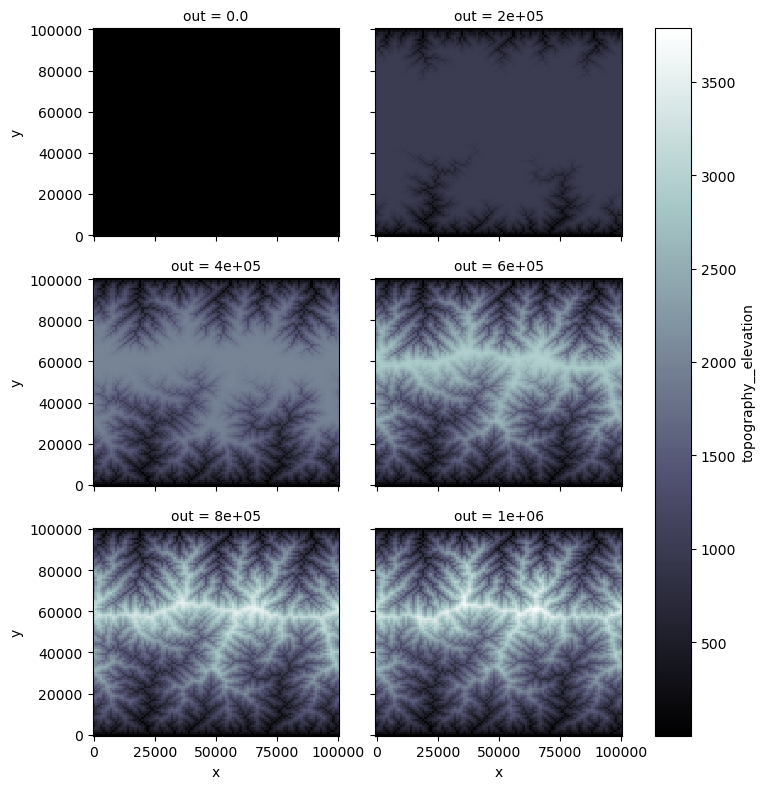

In [6]:
time_sel = np.arange(0, 1.01e6, 2e5)
ds_out_woc.sel(out=time_sel).topography__elevation.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='bone')

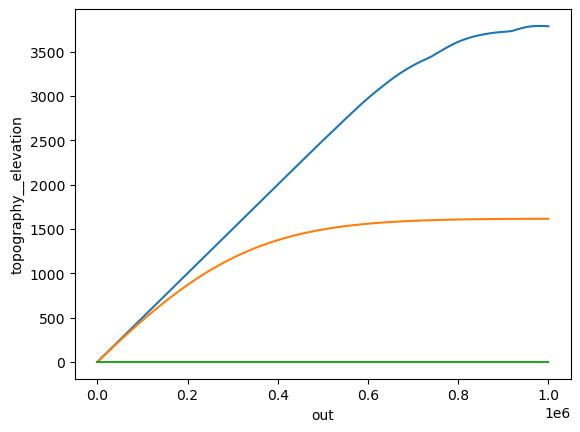

In [7]:
ds_out_woc.topography__elevation.max(('x', 'y')).plot()
ds_out_woc.topography__elevation.mean(('x', 'y')).plot()
ds_out_woc.topography__elevation.min(('x', 'y')).plot()

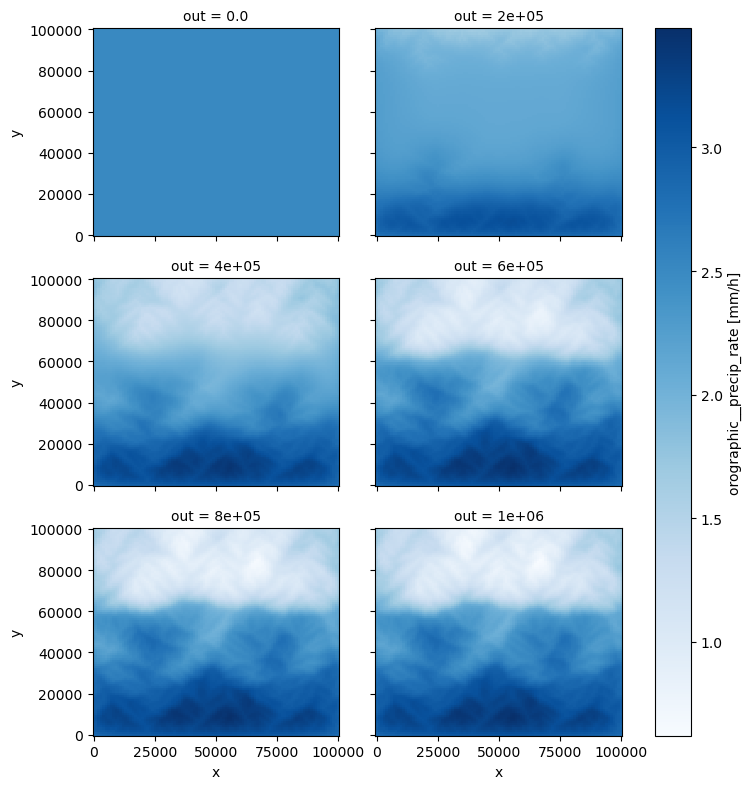

In [8]:
ds_out_woc.sel(out=time_sel).orographic__precip_rate.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='Blues')

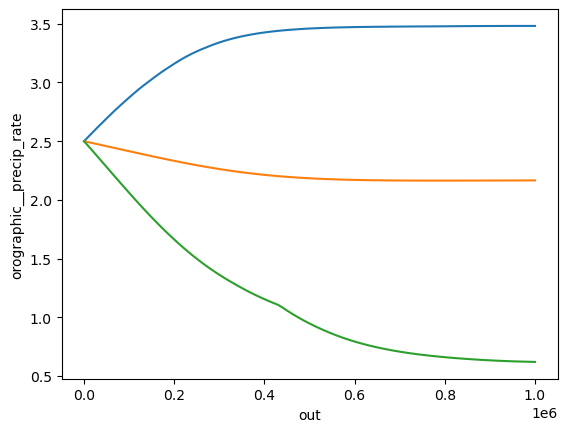

In [9]:
ds_out_woc.orographic__precip_rate.max(('x', 'y')).plot()
ds_out_woc.orographic__precip_rate.mean(('x', 'y')).plot()
ds_out_woc.orographic__precip_rate.min(('x', 'y')).plot()

We can also explore the results using a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which extends the capabilities of the xarray library. We convert the file using the build-in function **ext.get_dataframe** provided here.

In [10]:
dtf_woc = ext.get_dataframe(ds_out_woc)
dtf_woc

,out,taxon_id,ancestor_id,trait_elev,trait_prep,y,x
0,0.0,1.0,0.0,0.250000,0.750000,29784.009062,97669.976670
1,0.0,1.0,0.0,0.250000,0.750000,61916.101637,38019.573502
2,0.0,1.0,0.0,0.250000,0.750000,30175.742962,92324.623376
3,0.0,1.0,0.0,0.250000,0.750000,17484.645113,26169.242386
4,0.0,1.0,0.0,0.250000,0.750000,49550.519522,31909.705841
...,...,...,...,...,...,...,...
59659,1000000.0,1718.0,1678.0,0.566949,0.707909,46751.344869,56367.863345
59660,1000000.0,1718.0,1678.0,0.566949,0.707909,68114.848545,57531.023348
59661,1000000.0,1718.0,1678.0,0.566949,0.707909,49077.013389,10209.745748
59662,1000000.0,1718.0,1678.0,0.559992,0.851481,23255.130250,97079.264211


Then we can plot for some selected time steps the topography and the distribution of taxa by using [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) and [pyplot.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) in the provided
plotting function **ext.plot_topo_taxa**

Notice that on each time step, each taxon is depicted with a different marker and colour. 

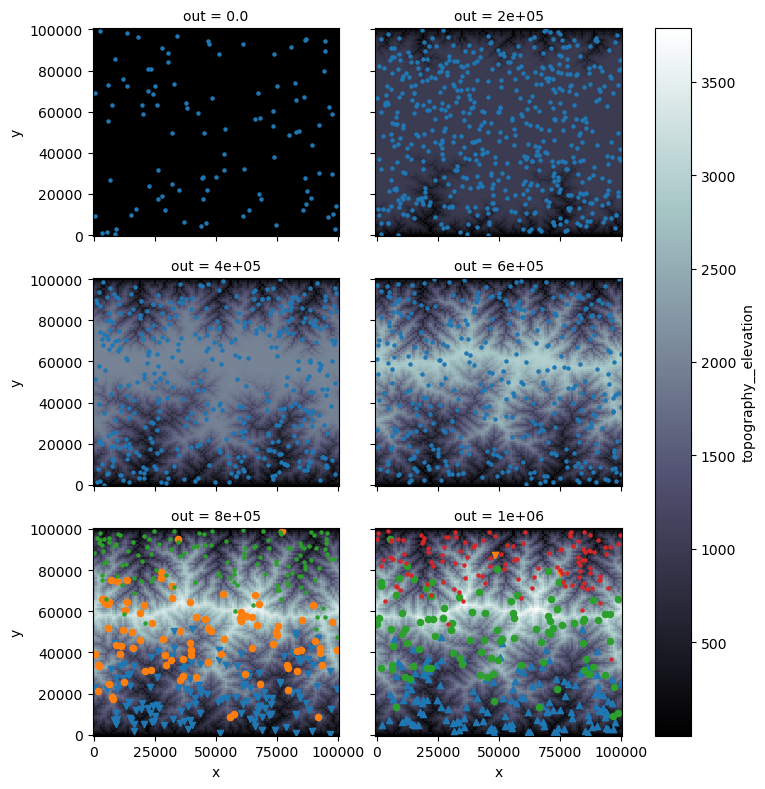

In [11]:
ext.plot_topo_taxa(ds_out_woc, dtf_woc, time_sel)

The temporal dynamics for the number of individuals and taxon richness can be explored using a combination of [pandas operations](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#flexible-apply) and basic [pyplot routines](https://matplotlib.org/stable/tutorials/introductory/pyplot.html). The temporal and spatial distribution of the trait is shown with [two-dimensional histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html), where the darker the colour shows an increased frequency/number of individuals with a trait value at particular time or location along the Y axis.

/Users/eac/Documents/GitHub/adascape/notebooks/extra_func.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  axs2_2.plot(dtf.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)


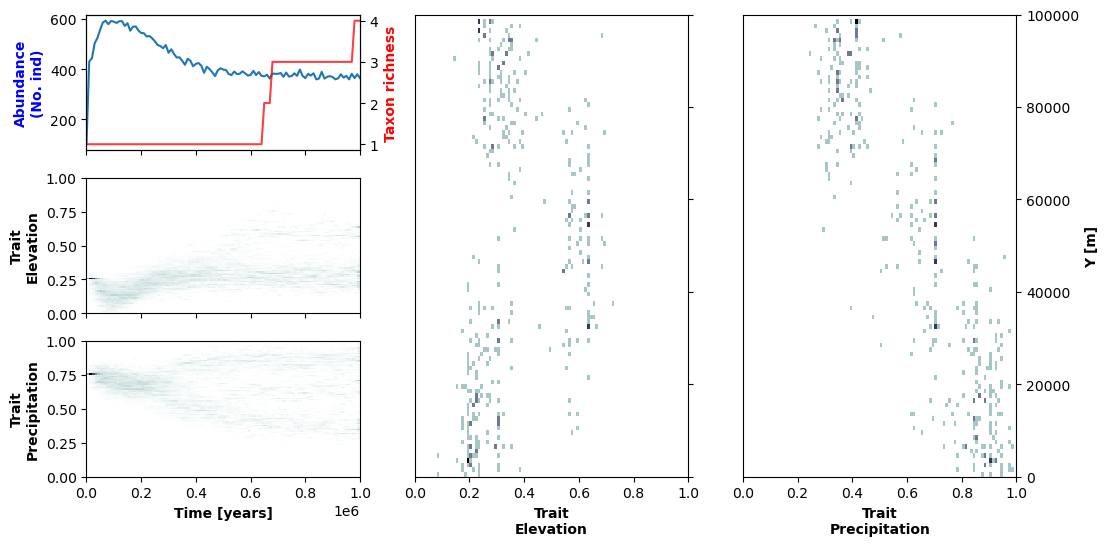

In [12]:
ext.plot_temp_dyn_2traits(dtf_woc)

## Speciation with trait-mediated competition

To run the eco-evolutionary model with the trait-mediated competition we need to modify the parameter $\mathbf{\sigma_u}$ to be a value < 1. We can update the values of the parameters we setup earlier in the file **ds_in** as:

In [13]:
with adascape_IR12_model, xs.monitoring.ProgressBar():
    ds_out_wic = ds_in.xsimlab.update_vars(input_vars={'life': {
            'sigma_u':0.2,
            'K':25
        }
    }   
    ).xsimlab.run(check_dims='transpose')

             0% | initialize 

Similarly as before we can visually explore the results of the model

In [14]:
dtf_wic = ext.get_dataframe(ds_out_wic)

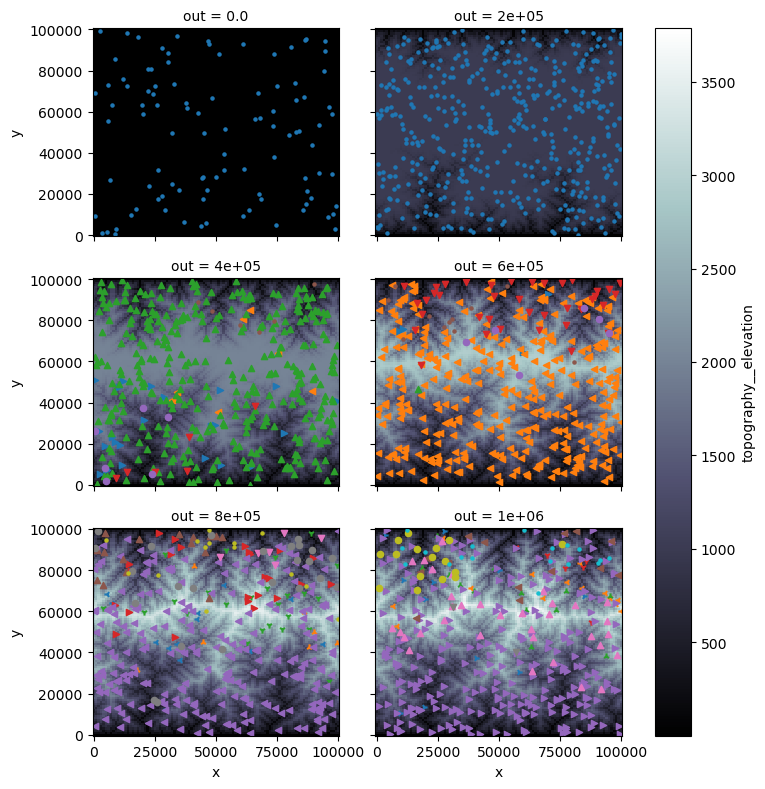

In [15]:
ext.plot_topo_taxa(ds_out_wic, dtf_wic, time_sel)

/Users/eac/Documents/GitHub/adascape/notebooks/extra_func.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  axs2_2.plot(dtf.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)


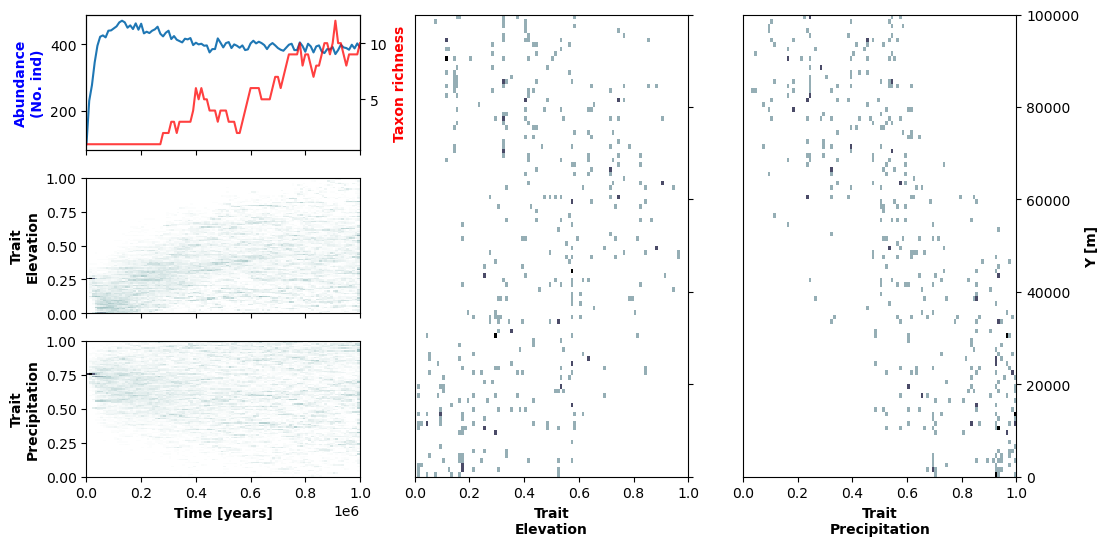

In [16]:
ext.plot_temp_dyn_2traits(dtf_wic)

In [17]:
tree1 = dtf_woc.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

In [18]:
tree2 = dtf_wic.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

In [19]:
tree1.print_plot()

                                               /++++++++++++++++++++++++++ 1716
                                               |                               
++++++++++++++++++++++++++++++++++++++++++++++++                       /++ 1717
                                               | /++++++++++++++++++++++       
                                               \++                     \++ 1718
                                                 |                             
                                                 \++++++++++++++++++++++++ 1719
                                                                               
                                                                               


In [20]:
tree2.print_plot()

                      /--------------------------------------------------+ 373 
                      |                                                        
                      |/--------------------------------------++++++++++++ 1040
                      ||                                                       
                      ||    /-----------------------------------------++++ 895 
                      ||    |                                                  
                      ||    | /-----------------------------------------++ 854 
                      ||    | |                                                
                      ||    | |     /----------------------------------+++ 1216
                      ||    | |     |                                          
                      ||    | |     |     /----------------------------+++ 1479
                      ||    | |     |     |                                    
                      ||    | |  /+++   

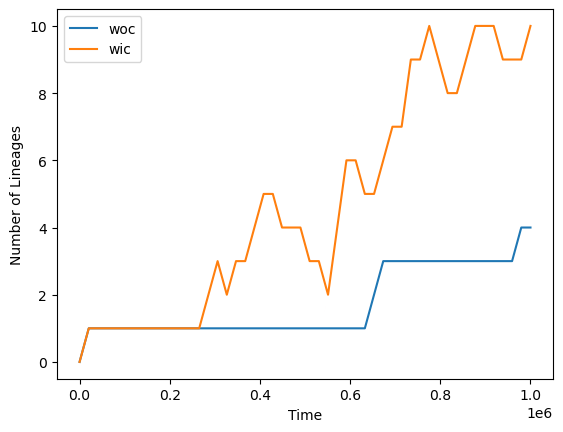

In [21]:
time_steps = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps]
ltt2=[tree2.num_lineages_at(t) for t in time_steps]
plt.plot(time_steps, ltt1, label='woc')
plt.plot(time_steps, ltt2, label='wic')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()